In [67]:
base_dir = '../../../../1.YL/HWs/Required-files-for-projects/Datasets/2.PEOPLE/filtered'  # Directory containing class folders
target_count = 1000  # Target number of images per class

In [68]:
import os
import random, numpy as np
import cv2
import tensorflow as tf
import imghdr

from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

### Create Augmented Images

In [69]:
def rotate_image(image_path, degrees):
    """Rotate the image by a specific degree and return it."""
    try:
        with Image.open(image_path) as img:
            rotated = img.rotate(degrees, expand=True, fillcolor=tuple(np.mean(np.array(img)[0,:], axis=0).astype(int)))
            # rotated = img.rotate(degrees, expand=True)
            return rotated
    except Exception as e:
        print(f"Error rotating image {image_path}: {e}")
        return None

def augment_images(input_dir, output_dir, target_count):
    """Augment images in the input directory to reach the target count, saving them to the output directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = [f for f in os.listdir(input_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(images)
    augment_count = target_count - current_count

    print(f"Class {os.path.basename(input_dir)} - Current count: {current_count}, Augmenting {augment_count} images to reach {target_count}.")

    for i in range(augment_count):
        img_name = random.choice(images)
        img_path = os.path.join(input_dir, img_name)
        degrees = random.uniform(0, 360)  # Random rotation degree between 0 and 360

        rotated_img = rotate_image(img_path, degrees)
        if rotated_img is not None:
            # Convert image to RGB if it's in RGBA or P mode
            if rotated_img.mode in ['RGBA', 'P']:
                rotated_img = rotated_img.convert('RGB')
            new_img_name = f"{os.path.splitext(img_name)[0]}_rotated_{i}.jpg"
            rotated_img.save(os.path.join(output_dir, new_img_name))

def create_augmented_images():
    for class_name in os.listdir(base_dir):
        input_class_dir = os.path.join(base_dir, class_name)
        output_class_dir = os.path.join(base_dir, class_name + '_augmented')

        if os.path.isdir(input_class_dir):
            augment_images(input_class_dir, output_class_dir, target_count)

# create_augmented_images()

### Dirty Image Cleaner

In [70]:

def dirty_image_cleaner():
    image_exts = ['jpeg','jpg', 'bmp', 'png']
    for image_class in os.listdir(base_dir): 
        for image in os.listdir(os.path.join(base_dir, image_class)):
            image_path = os.path.join(base_dir, image_class, image)
            try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
            
# dirty_image_cleaner()

### Get Data

In [92]:
data = tf.keras.utils.image_dataset_from_directory(base_dir)

Found 5925 files belonging to 6 classes.


In [72]:
tf.config.list_physical_devices('GPU') 

[]

In [93]:
class_names = data.class_names

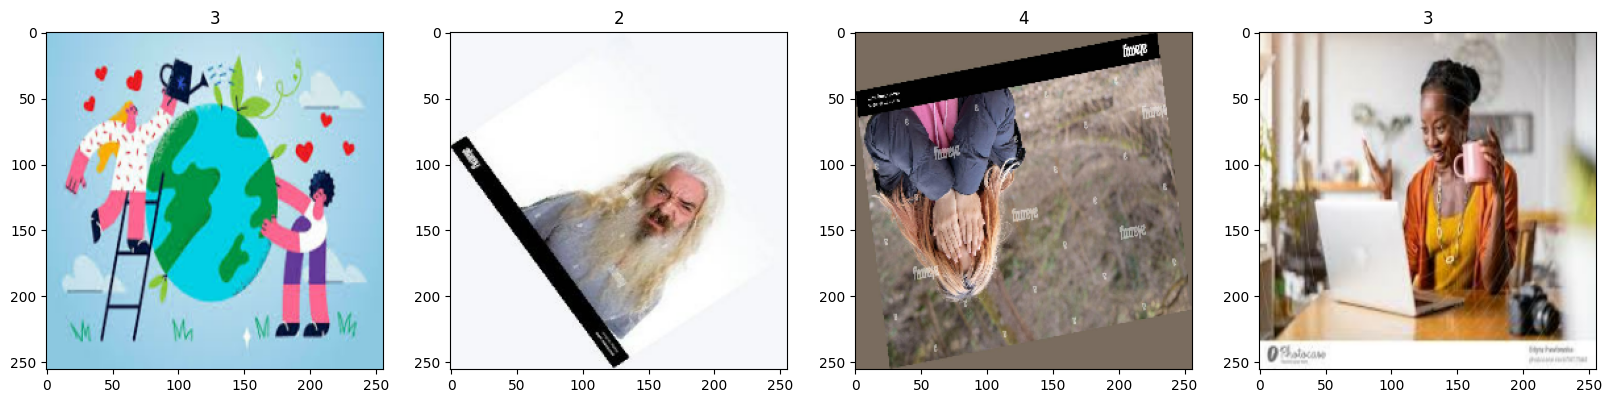

In [74]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [75]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          ...,
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ]],
 
         [[0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          ...,
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ]],
 
         [[0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          ...,
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ],
          [0.57254905, 0.41960785, 0.2901961 ]],
 
         ...,
 
         [[0.57254905, 0.41960785, 0.2901961 ],
          [0.57254

In [76]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [77]:
train_size

130

In [78]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [79]:
model = Sequential()

In [80]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [81]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,910 (14.11 MB)

 Trainable params: 3,697,910 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2449 - loss: 1.7949

2024-06-11 11:41:33.362404: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 220ms/step - accuracy: 0.2453 - loss: 1.7940 - val_accuracy: 0.3454 - val_loss: 1.5857
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4117 - loss: 1.4936

2024-06-11 11:42:00.580020: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.4119 - loss: 1.4932 - val_accuracy: 0.4046 - val_loss: 1.4736
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5439 - loss: 1.2081

2024-06-11 11:42:29.012686: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - accuracy: 0.5441 - loss: 1.2077 - val_accuracy: 0.4417 - val_loss: 1.4360
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6888 - loss: 0.8828

2024-06-11 11:42:56.874554: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - accuracy: 0.6890 - loss: 0.8822 - val_accuracy: 0.4772 - val_loss: 1.5194
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8296 - loss: 0.5133

2024-06-11 11:43:24.433921: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - accuracy: 0.8298 - loss: 0.5127 - val_accuracy: 0.4882 - val_loss: 1.6915
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9078 - loss: 0.2965

2024-06-11 11:43:52.181697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step - accuracy: 0.9080 - loss: 0.2961 - val_accuracy: 0.5372 - val_loss: 2.1971
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9649 - loss: 0.1228

2024-06-11 11:44:19.266185: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.9649 - loss: 0.1227 - val_accuracy: 0.5431 - val_loss: 2.5424
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9859 - loss: 0.0605

2024-06-11 11:44:46.505598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.9859 - loss: 0.0606 - val_accuracy: 0.5515 - val_loss: 2.7877
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9755 - loss: 0.1062

2024-06-11 11:45:13.637309: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.9755 - loss: 0.1061 - val_accuracy: 0.5566 - val_loss: 2.9051
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9895 - loss: 0.0419

2024-06-11 11:45:41.146659: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - accuracy: 0.9895 - loss: 0.0419 - val_accuracy: 0.5802 - val_loss: 2.7759


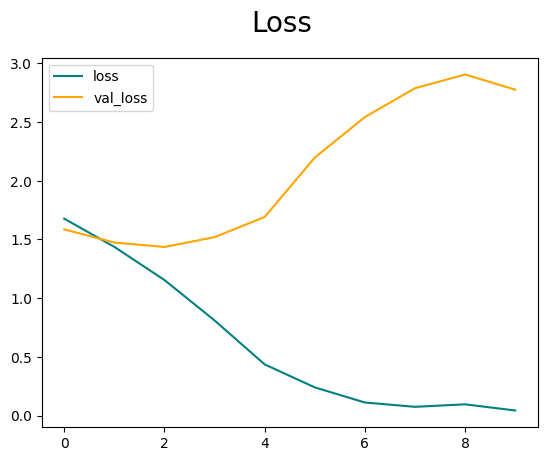

In [83]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

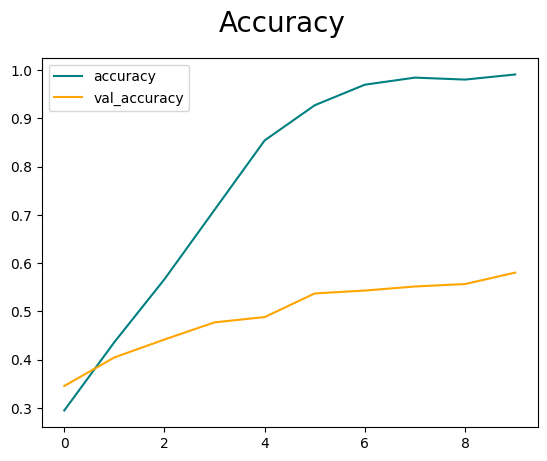

In [84]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

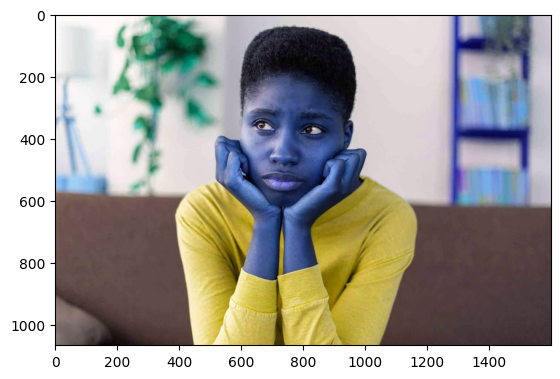

In [85]:
img = cv2.imread('img.png')
plt.imshow(img)
plt.show()

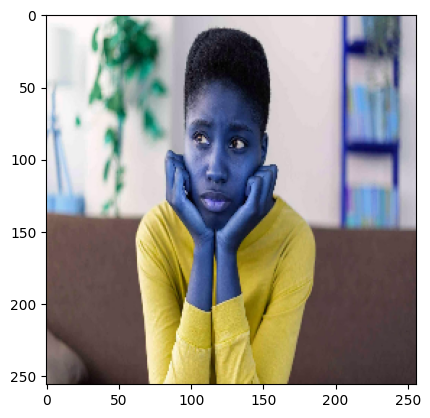

In [86]:
resized_image = tf.image.resize(img, (256,256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [100]:
pred = model.predict(np.expand_dims(resized_image/255, 0))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[2.1660523e-03, 3.4101772e-01, 1.6513161e-04, 1.0815199e-04,
        6.4885533e-01, 7.6876106e-03]], dtype=float32)

In [101]:
class_names[np.argmax(pred)]

'sad'

### Save the Model

In [89]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','imageclassifier.keras'))

In [90]:
new_model = load_model('models/imageclassifier.keras')

In [94]:
results = new_model.predict(np.expand_dims(resized_image/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [97]:
class_names[np.argmax(results)]

'sad'